In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz 
from skfuzzy import control as ctrl
from tqdm.auto import tqdm
from matplotlib import cm
import matplotlib.patches as mpatches

In [ ]:
# importing data

df_in = pd.read_csv("in/Example.csv")
df_in.columns = ['Depth','toc','s1','s2',"s3",'Tmax','hi','oi','Ro']

In [ ]:
def fuzzy_maturation(input_df,**kwargs):
    
    #input: a dataframe necessarily containing Depth, toc, hi, and oi (with these names)
    #output: same as the input but with the classification

    #note that there is no test if the input_df is complete for all columns.
    
    #Organic facies number - 7 categories following Jones, R.W., 1987. Organic Facies,
    #in: Brooks, J., Welte, D. (Eds.), Advances in Petroleum Geochemistry. Academic Press, London, pp. 78–80

   
    debug = kwargs.get('debug',False) # If set to True, also exports a dataframe with the undefined facies.
    trust = kwargs.get('trust','COT') #  the default is to trust COT
    
    
    if trust not in ['COT','IH']:
        print(f'Você forneceu a opção "trust={trust}" que não é reconhecida.')
        return 

    # creating output_df
    output_df = input_df
    
    # definição das classes de saida  
    # **CLASSIC**
    of_nclass = 7
    of_class = ['A','AB','B','BC','C','CD','D']
    
    # **RECLASSIFICATION**
    if trust == 'COT':
        of_RE_nclass = 4
        of_RE_class = ['BC+','CD+++','CD++','CD+']
        of_RE_alter = ['BC','CD','CD','CD']
    elif trust == 'IH':
        of_RE_nclass = 4
        of_RE_class = ['B-','B--','BC--','C-']        
        of_RE_alter = ['B','B','BC','C']

    # toc: classes of total carbono orgânico 
    toc_nclass = 3
    toc_class = ['low','high','very high']
    toc_class_bounds = [[0,1],
                    [1,3],
                    [3,20]]
    
    # hi: classes of hydrogen index
    hi_nclass = 7
    hi_class = ['ultra low','very low','low','intermediate','high','very high','ultra high']
    hi_class_bounds = [[0,50],
                   [50,125],
                   [125,250],
                   [250,400],
                   [400,650],
                   [650,850],
                   [850,1500]]

    #oi: Classes of oxygen índex
    oi_nclass = 7
    oi_class =  ['ultra low','very low','low','mid low','mid high','mid wide','wide']
    oi_class_bounds = [[10,30],
                   [20,50],
                   [30,80],
                   [40,80],
                   [50,150],
                   [40,150],
                   [20,200]]
    
    #oi_RE: Classes of oxygen índex (short) for reclassification
    oi_RE_nclass = 3
    oi_RE_class =  ['low','mid wide','high']
    oi_RE_class_bounds = [[10,80],
                          [40,150],
                          [120,200]]   
    

    # Definition of fuzzy model (based on values min/max) and resolution stated below
    dtoc = 0.5
    dhi = 1
    doi = 1

    TOC = ctrl.Antecedent(np.arange(np.min(toc_class_bounds),np.max(toc_class_bounds), dtoc),'toc')
    HI = ctrl.Antecedent(np.arange(np.min(hi_class_bounds),np.max(hi_class_bounds), dhi),'hi')
    OI = ctrl.Antecedent(np.arange(np.min(oi_class_bounds),np.max(oi_class_bounds), doi),'oi')
    OI_RE = ctrl.Antecedent(np.arange(np.min(oi_RE_class_bounds),np.max(oi_RE_class_bounds), doi),'oi_re')
    
    # Consequents
    Organic_Facies = ctrl.Consequent(np.arange(0, of_nclass + 1, 1), 'of')
    Organic_Facies_RE = ctrl.Consequent(np.arange(0, of_nclass + 1, 1), 'of_re')

    # Initialization
    for ii,tclass in enumerate(toc_class):
        if ii == 0:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [np.min(toc_class_bounds),
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             toc_class_bounds[ii+1][0]])
        elif ii == len(toc_class)-1:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [toc_class_bounds[ii-1][1],
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             np.max(toc_class_bounds)])
        else:
            TOC[tclass] = fuzz.trapmf(TOC.universe, [toc_class_bounds[ii-1][1],
                                             toc_class_bounds[ii][0],
                                             toc_class_bounds[ii][1],
                                             toc_class_bounds[ii+1][0]])
    for ii,hiclass in enumerate(hi_class):
        if ii == 0:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.min(hi_class_bounds),
                                             hi_class_bounds[ii][0],
                                             hi_class_bounds[ii][1],
                                             np.mean(hi_class_bounds[ii+1][:])])
        elif ii == len(hi_class)-1:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.mean(hi_class_bounds[ii-1][:]),
                                             hi_class_bounds[ii][0],
                                             hi_class_bounds[ii][1],
                                             np.max(hi_class_bounds)])
        else:
            HI[hiclass] = fuzz.trapmf(HI.universe, [np.mean(hi_class_bounds[ii-1][:]),
                                            hi_class_bounds[ii][0],
                                            hi_class_bounds[ii][1],
                                            np.mean(hi_class_bounds[ii+1][:])])
    
    #NOTE: for OI (Oxygen Index), a Gaussian membership function is used.
    #This choice was made based on the wide distribution of OI.
    
    for ii,oiclass in enumerate(oi_class):
        OI[oiclass] = fuzz.gaussmf(OI.universe,np.mean(oi_class_bounds[ii][:]),
                                         np.std(oi_class_bounds[ii][:]))

    for ii,oiREclass in enumerate(oi_RE_class):
        OI_RE[oiREclass] = fuzz.gaussmf(OI_RE.universe,np.mean(oi_RE_class_bounds[ii][:]),
                                         np.std(oi_RE_class_bounds[ii][:]))

    # Crisp triangular output membership function
    for ii,ofclass in enumerate(of_class):
        Organic_Facies[ofclass] = fuzz.trimf(Organic_Facies.universe,[ii-1,ii,ii+1])
    
    for ii,ofREclass in enumerate(of_RE_class):
        Organic_Facies_RE[ofREclass] = fuzz.trimf(Organic_Facies_RE.universe,[ii-1,ii,ii+1])


    # FUZZY rules   

    rule1 = ctrl.Rule(TOC['very high'] & HI['ultra high'] & OI['ultra low'], Organic_Facies['A']) 
    rule2 = ctrl.Rule(TOC['very high'] & HI['very high'] & OI['very low'], Organic_Facies['AB'])
    rule3 = ctrl.Rule(TOC['very high'] & HI['high'] & OI['low'], Organic_Facies['B'])
    rule4 = ctrl.Rule(TOC['high'] & HI['intermediate'] & OI['mid low'], Organic_Facies['BC'])
    rule5 = ctrl.Rule(TOC['high'] & HI['low'] & OI['mid high'], Organic_Facies['C'])
    rule6 = ctrl.Rule(TOC['low'] & HI['very low'] & OI['mid wide'], Organic_Facies['CD'])
    rule7 = ctrl.Rule(TOC['low'] & HI['ultra low'] & OI['wide'], Organic_Facies['D'])
    
    # Note that these are the rules for reclassification.
    
    if trust=='COT':
        rule8 = ctrl.Rule(TOC['high'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['BC+'])
        rule9 = ctrl.Rule(TOC['low'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['CD+++'])
        rule10 = ctrl.Rule(TOC['low'] & HI['intermediate'] & OI_RE['mid wide'], Organic_Facies_RE['CD++'])
        rule11 = ctrl.Rule(TOC['low'] & HI['low'] & OI_RE['high'], Organic_Facies_RE['CD+'])
    elif trust=='IH':
        rule8 = ctrl.Rule(TOC['high'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['B-'])
        rule9 = ctrl.Rule(TOC['low'] & HI['high'] & OI_RE['low'], Organic_Facies_RE['B--'])
        rule10 = ctrl.Rule(TOC['low'] & HI['intermediate'] & OI_RE['mid wide'], Organic_Facies_RE['BC--'])
        rule11 = ctrl.Rule(TOC['low'] & HI['low'] & OI_RE['high'], Organic_Facies_RE['C-'])       

    maturation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, \
                                          rule5, rule6, rule7])
    
    maturation_ctrl_RE = ctrl.ControlSystem([rule8, rule9, rule10, rule11])
    
    # driver fuzzy starts here
    maturation_apply = ctrl.ControlSystemSimulation(maturation_ctrl)
    maturation_apply_RE = ctrl.ControlSystemSimulation(maturation_ctrl_RE)

    # Main loop for the entire input.
    output_df = output_df.assign(of=-99.0)
    output_df = output_df.assign(of_class='??')
    output_df = output_df.assign(quality='error')
    output_df = output_df.assign(observ='input error')

    # ***  Handles invalid input
    for index,row in tqdm(input_df.iterrows(),total=len(input_df)):
        if row.toc < np.min(toc_class_bounds) or row.toc >np.max(toc_class_bounds):
            print(f'***warning: toc invalid Depth:{row.Depth} inputs:[{row.toc:.2f}:{row.hi:4.0f}:{row.oi:4.0f}]')
        if row.hi < np.min(hi_class_bounds) or row.hi >np.max(hi_class_bounds):
            print(f'***warning: HI invalid Depth:{row.Depth} inputs:[{row.toc:.2f}:{row.hi:4.0f}:{row.oi:4.0f}]')
        if row.oi < np.min(oi_class_bounds) or row.oi >np.max(oi_class_bounds):
            print(f'***warning: oi invalid Depth:{row.Depth} inputs:[{row.toc:.2f}:{row.hi:4.0f}:{row.oi:4.0f}]')
        maturation_apply.inputs({'toc': float(row.toc),'hi': float(row.hi),'oi': float(row.oi)})
        maturation_apply_RE.inputs({'toc': float(row.toc),'hi': float(row.hi),'oi_re': float(row.oi)})
        
        try:
            maturation_apply.compute()
            
            #Rounds the defuzzified output float to 2 decimal places.
            output_df.loc[index,'of'] = round(maturation_apply.output["of"],2)
            # Uses the nearest integer to select the class.
            ii_class = np.rint(maturation_apply.output["of"]) 
            
            output_df.loc[index,'of_class'] = of_class[int(ii_class)]
            output_df.loc[index,'quality'] = 'good'
            output_df.loc[index,'observ'] = ''
            
        except:
            try:
                maturation_apply_RE.compute()
                
                # Rounds the defuzzified output float to 2 decimal places.
                output_df.loc[index,'of'] = round(maturation_apply_RE.output["of_re"],2)
                # utiliza o inteiro mais próximo para escolher a classe
                ii_class = np.rint(maturation_apply_RE.output["of_re"]) 
                output_df.loc[index,'of_class'] = of_RE_alter[int(ii_class)]
                output_df.loc[index,'quality'] = f'regular'
                output_df.loc[index,'observ'] = f'regular {of_RE_class[int(ii_class)]}'
            
            except:
            
                # Uses the nearest integer to select the class.
                print(f' Erro in defuzzing (RECLASS) on índice:{index} Depth:{row.Depth:.2f} m')
            
            if debug:
                print(f'Debugging...',end='')
                atclass = ''
                ahiclass = ''
                aoiclass = ''
                
                for ii,tclass in enumerate(toc_class):
                    if row.toc >= toc_class_bounds[ii][0] and row.toc <= toc_class_bounds[ii][1]:
                        atclass = f'{atclass}|{tclass}'
                atclass = f'{atclass}|'
                        
                for ii,hiclass in enumerate(hi_class):
                    if row.hi >= hi_class_bounds[ii][0] and row.hi <= hi_class_bounds[ii][1]:
                        ahiclass = f'{ahiclass}|{hiclass}'
                ahiclass = f'{ahiclass}|'
                        
                for ii,oiclass in enumerate(oi_RE_class):
                    if row.oi >= oi_RE_class_bounds[ii][0] and row.oi <= oi_RE_class_bounds[ii][1]:
                        aoiclass = f'{aoiclass}|{oiclass}'
                aoiclass = f'{aoiclass}|'
                
                print(f'COT:{row.toc:.3f} COT_class {atclass} '
                      f'IH {row.hi:.1f} IH_class {ahiclass} '
                      f'IO {row.oi:.1f} IO_class {aoiclass} ')
        

    return output_df

In [18]:
# running function
df_out = fuzzy_maturation(df_in,func='flat',debug=True)
df_out

  0%|          | 0/128 [00:00<?, ?it/s]

***warning: oi invalid Depth:2400.0 inputs:[1.01: 257: 430]
***warning: oi invalid Depth:2820.0 inputs:[1.07:  36: 264]
 Erro in defuzzing (RECLASS) on índice:6 Depth:2874.00 m
Debugging...COT:1.510 COT_class |high| IH 63.6 IH_class |very low| IO 137.1 IO_class |mid wide|high| 
 Erro in defuzzing (RECLASS) on índice:7 Depth:2883.00 m
Debugging...COT:1.680 COT_class |high| IH 74.4 IH_class |very low| IO 153.6 IO_class |high| 
 Erro in defuzzing (RECLASS) on índice:8 Depth:2892.00 m
Debugging...COT:1.600 COT_class |high| IH 68.1 IH_class |very low| IO 153.8 IO_class |high| 
 Erro in defuzzing (RECLASS) on índice:9 Depth:2901.00 m
Debugging...COT:1.810 COT_class |high| IH 79.6 IH_class |very low| IO 164.6 IO_class |high| 
 Erro in defuzzing (RECLASS) on índice:10 Depth:2910.00 m
Debugging...COT:1.610 COT_class |high| IH 54.0 IH_class |very low| IO 165.2 IO_class |high| 
 Erro in defuzzing (RECLASS) on índice:11 Depth:2919.00 m
Debugging...COT:1.550 COT_class |high| IH 49.0 IH_class |ultra

,Depth,toc,s1,s2,s3,Tmax,hi,oi,Ro,of,of_class,quality,observ
0,2400,1.010,2.29,2.60,4.34,378,257.4258,429.7030,-99999.00,4.00,C,good,
1,2820,1.070,0.25,0.39,2.83,319,36.4486,264.4860,0.25,5.75,D,good,
2,2829,0.681,0.62,0.92,1.35,290,135.0955,198.2379,-99999.00,4.55,CD,good,
3,2847,0.980,0.44,0.83,1.43,288,84.6939,145.9184,-99999.00,5.13,CD,good,
4,2856,1.270,0.54,1.01,1.76,290,79.5276,138.5827,-99999.00,5.33,CD,good,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,5049,1.700,1.15,3.47,1.83,441,204.1176,107.6471,-99999.00,3.90,C,good,
124,5052,1.300,1.00,2.69,2.27,440,206.9231,174.6154,-99999.00,4.00,C,good,
125,5055,1.220,0.95,2.41,1.59,446,197.5410,130.3279,-99999.00,4.00,C,good,
126,5058,1.170,0.96,2.42,2.54,440,206.8376,217.0940,-99999.00,4.00,C,good,


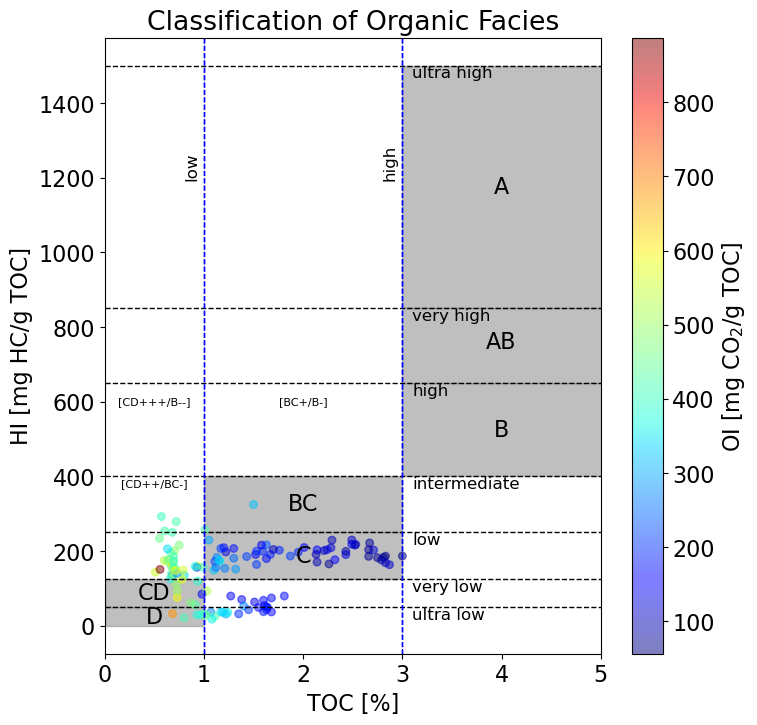

In [19]:
# vamos ao um pequeno plot para mostrar a relação entre TOC e HI


plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(8,8))

# definição das classes e áreas 
D_class = [(0,0),(0,50),(1,50),(1,0),(0,0)]
CD_class = [(0,50),(0,125),(1,125),(1,50),(0,50)]
C_class = [(1,125),(3,125),(3,250),(1,250),(1,125)]
BC_class = [(1,250),(3,250),(3,400),(1,400),(1,250)]
B_class = [(3,400),(20,400),(20,650),(3,650),(3,400)]
AB_class = [(3,650),(20,650),(20,850),(3,850),(3,650)]
A_class = [(3,850),(20,850),(20,1500),(3,1500),(3,850)]

ax.add_patch(plt.Polygon(D_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(CD_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(C_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(BC_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(B_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(AB_class,color='gray',alpha=0.5))
ax.add_patch(plt.Polygon(A_class,color='gray',alpha=0.5))

# classes
plt.text(0.5,25,'D',fontsize=16,va='center',ha='center')
plt.text(0.5,87.5,'CD',fontsize=16,va='center',ha='center')
plt.text(2,187.5,'C',fontsize=16,va='center',ha='center')
plt.text(2,325,'BC',fontsize=16,va='center',ha='center')
plt.text(4,525,'B',fontsize=16,va='center',ha='center')
plt.text(4,759,'AB',fontsize=16,va='center',ha='center')
plt.text(4,1175,'A',fontsize=16,va='center',ha='center')

# plota os valores em scatter ###
plt.scatter(df_in.toc,df_in.hi,c=df_in.oi,
            s=30,cmap=cm.jet,alpha=0.5,label='SES189')

# ###############################
plt.xlabel('TOC [%]')
plt.xlim([0,5])
plt.ylabel('HI [mg HC/g TOC]')
plt.title('Classification of Organic Facies')

his = [50,125,250,400,650,850,1500]
his_text = ['ultra low','very low','low','intermediate','high','very high','ultra high']

for yp,histext in enumerate(his_text):
    plt.axhline(his[yp],linestyle='--',color='k',linewidth=1)
    plt.text(3.1,his[yp],histext,fontsize=12,va='top')
    
cots = [1,3]
cots_text = ['low','high']
for xp,cotstext in enumerate(cots_text):
    plt.axvline(cots[xp],linestyle='--',color='b',linewidth=1)
    plt.text(cots[xp]-0.2,1200,cotstext,fontsize=12,rotation=90,ha='left')
    
plt.axvline(1,linestyle='--',color='b',linewidth=1)
plt.axvline(3,linestyle='--',color='b',linewidth=1)

# classificação extra
plt.text(0.5,600,'[CD+++/B--]',fontsize=8,va='center',ha='center')
plt.text(2,600,'[BC+/B-]',fontsize=8,va='center',ha='center')
plt.text(0.5,380,'[CD++/BC-]',fontsize=8,va='center',ha='center')

cbar = plt.colorbar()
cbar.ax.set_ylabel('OI [mg CO$_{2}$/g TOC]', rotation=90)

plt.show()